In [8]:
!bash --login -c "poetry update"

Updating dependencies
Resolving dependencies... (9.0s)

No dependencies to install or update


# Option valuation model based on historical prices

This code assumes `aws configure` has been run in the environment of the notebook.

In [3]:
import optionspricing
import boto3
import helpers
import pandas
from dotenv import load_dotenv

load_dotenv()

BINANCE_ETH = "ETHUSDT"
BINANCE_BTC = "BTCUSDT"
BINANCE_XRP = "XRPUSDT"
BINANCE_SOL = "SOLUSDT"
BINANCE_MATIC = "MATICUSDT"

BINANCE_SYMBOL = BINANCE_ETH
  
USD_QUOTES = ["SOL", "XRP", "MATIC"]
quote_in_usd = len([prefix for prefix in USD_QUOTES if BINANCE_SYMBOL.upper().startswith(prefix)]) > 0

s3 = boto3.resource('s3')

data_file = helpers.fetch_object(s3, "test-binance-prices-255120844515", f"{BINANCE_SYMBOL}-full.csv.zip")
prices_df = pandas.read_csv(data_file, compression='zip', header=0, index_col="dateTime")
prices_df.index = pandas.to_datetime(prices_df.index)

## Option valuation model: input parameters here

In [6]:
target_period_hours = 2 * 24
strikes_universe_size = 43
CUT_OFF_YEAR_MONTH = (2021, 1)

instrument_code = BINANCE_SYMBOL[:-4]

headers = {"Content-Type": "application/json"}
base_url = "https://www.deribit.com/api/v2/public"

trading_model = optionspricing.TradingModel(base_url, headers, instrument_code, target_period_hours)
trading_model.cutoff_year_month(CUT_OFF_YEAR_MONTH)
target_expiry = trading_model.target_expiry
underlying_price = trading_model.underlying_price
remaining_hours = trading_model.remaining_hours

option_chain_df = trading_model.evaluate(prices_df, strikes_universe_size)
simulation = trading_model.simulate_strategy_long_straddle(option_chain_df, strikes_universe_size, quote_in_usd=quote_in_usd)
print(simulation)

target expiry: Thu 01 Aug, 08:00 (49 hours left)
current price: 3320.47
-------------------------------
hit ratio: 45%
cost: 0.026 / value: 0.035, gain% = 0.97%
($) cost: 84.67 / value: 116.96, average gain = 32.29
buy put 3300.0
buy call 3350.0
-------------------------------
hit ratio: 43%
cost: 0.019 / value: 0.030, gain% = 1.00%
($) cost: 64.75 / value: 98.04, average gain = 33.29
buy put 3275.0
buy call 3375.0
-------------------------------
hit ratio: 40%
cost: 0.015 / value: 0.025, gain% = 0.93%
($) cost: 51.47 / value: 82.24, average gain = 30.78
buy put 3250.0
buy call 3400.0
-------------------------------
hit ratio: 37%
cost: 0.012 / value: 0.021, gain% = 0.88%
($) cost: 39.85 / value: 69.06, average gain = 29.22
buy put 3225.0
buy call 3425.0


In [102]:
simulation.options_chain

,value_call,value_call_pct,call_bid,call_ask,value_put,value_put_pct,put_bid,put_ask
strike,,,,,,,,
3050.0,126.209997,NaN,0.0360,0.0415,9.103572,0.002879,0.0034,0.0041
3075.0,104.305922,NaN,0.0315,0.0345,12.199497,0.003858,0.0045,0.0055
3100.0,83.538378,NaN,0.0230,0.0290,16.431953,0.005197,0.0065,0.0070
3125.0,64.449229,NaN,0.0195,0.0220,22.342804,0.007066,0.0080,0.0090
3150.0,47.901750,NaN,0.0150,0.0165,30.795325,0.009739,0.0110,0.0120
3175.0,35.123000,0.011108,0.0105,0.0120,43.016574,NaN,0.0145,0.0160
3200.0,25.929310,0.008200,0.0075,0.0085,58.822885,NaN,0.0185,0.0215
3225.0,19.162961,0.006060,0.0050,0.0060,77.056535,NaN,0.0225,0.0285
3250.0,14.166475,0.004480,0.0033,0.0041,97.060050,NaN,0.0285,0.0345


# Sanity checks

In [14]:

trading_model = optionspricing.TradingModel(base_url, headers, instrument_code, target_period_hours)
size = 6
option_chain_df = trading_model.evaluate(prices_df, strikes_universe_size=size)
put_weights = [0.] * (2 * size + 1)
call_weights = [0.] * (2 * size + 1)
put_weights[size - 5] = +1.
put_weights[size - 1] = -1.
call_weights[size + 1] = -1.
call_weights[size + 5] = +1.

simulation = trading_model.simulate_strategy(option_chain_df, put_weights, call_weights, quote_in_usd=quote_in_usd)
print(simulation)

target expiry: Sun 07 Jul, 08:00 (49 hours left)
current price: 2858.15
-------------------------------
hit ratio: 58%
cost: -0.021 / value: -0.020, gain% = 0.15%
($) cost: -61.45 / value: -57.16, average gain = 4.29
buy put 2600.0
sell put 2800.0
sell call 2900.0
buy call 3000.0


<Axes: xlabel='dateTime'>

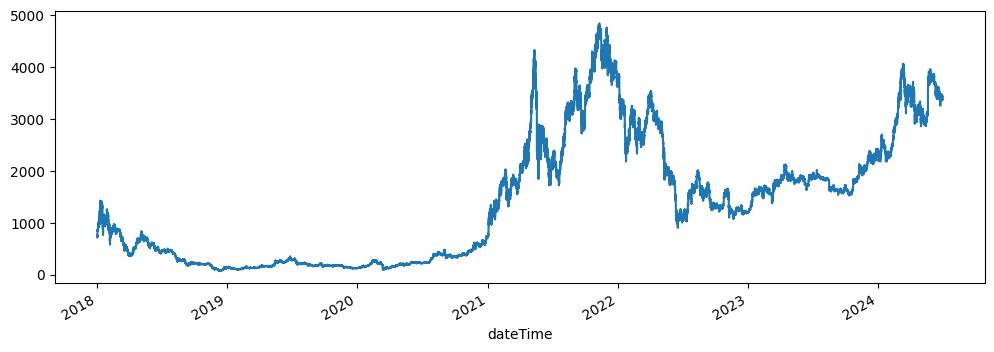

In [30]:
prices_df['close'].plot(figsize=(12,4))